In [2]:
from langgraph.graph import StateGraph,START,END
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI 
from dotenv import load_dotenv
from typing import TypedDict , Literal
from pydantic import BaseModel , Field 

c:\Users\dell\Desktop\Langgraph-learning\agent\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.7) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\Users\dell\Desktop\Langgraph-learning\agent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

In [4]:
class SentimentSchema(BaseModel):
    sentiment : Literal["positive", "negative", "neutral"] = Field(
        description="The sentiment of the review")
model = llm.with_structured_output(SentimentSchema)

In [14]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

diagnosis_model = llm.with_structured_output(DiagnosisSchema)

In [15]:
class ReviewState(TypedDict):
    review : str
    sentiment : Literal["positive","negative"]
    diagnosis : dict
    response : str

In [19]:
def find_sentiment(state:ReviewState):
    prompt = f'for the following review find out the sentiment \n {state["review"]}'
    output = model.invoke(prompt).sentiment
    return {'sentiment':output}

def check_sentiment(state: ReviewState) -> Literal["responding_positive_review", "diagnose_negative_review"]:
    if state['sentiment'] == 'positive':
        return 'responding_positive_review'
    else:
        return 'diagnose_negative_review'
    
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:\n\n\" {state['review']}\"\n Also, kindly ask the user to leave feedback on our website."""
    response = llm.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n""Return issue_type, tone, and urgency."""
    response = diagnosis_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.Write an empathetic, helpful resolution message."""
    response = llm.invoke(prompt).content
    return {'response': response}


In [20]:
graph = StateGraph(ReviewState)

graph.add_node("Find_sentiment",find_sentiment)
graph.add_node("responding_positive_review",positive_response)
graph.add_node("diagnose_negative_review",run_diagnosis)
graph.add_node("responding_negative_review",negative_response)

graph.add_edge(START,"Find_sentiment")
graph.add_conditional_edges("Find_sentiment",check_sentiment)
graph.add_edge("responding_positive_review",END)
graph.add_edge("diagnose_negative_review","responding_negative_review")
graph.add_edge("responding_negative_review",END)

workflow = graph.compile()

In [28]:
review_state = {
    "review":"The product was not good and I faced many issues while using it."}

result = workflow.invoke(review_state)


In [30]:
print(result['response'])

Subject: Re: Your recent UX feedback - [Issue Reference/Ticket Number if applicable]

Hi [User Name],

Thank you for reaching out and sharing your feedback regarding the recent UX issue you encountered.

I'm truly sorry to hear that your experience was disappointing. That's definitely not the impression we want to leave, and we appreciate you bringing it to our attention. Even though you've marked the urgency as 'low', please know that any feedback impacting your satisfaction and ease of use is incredibly important to us.

I've immediately escalated your specific feedback to our product and design teams. They are always keen to hear about real-world user experiences, especially when they highlight areas where we can improve usability and overall enjoyment of our platform.

While UX improvements can sometimes take a bit of time to thoroughly review, design, and implement, your input is a vital part of that process. We'll keep a close eye on this internally and will reach out if we need 

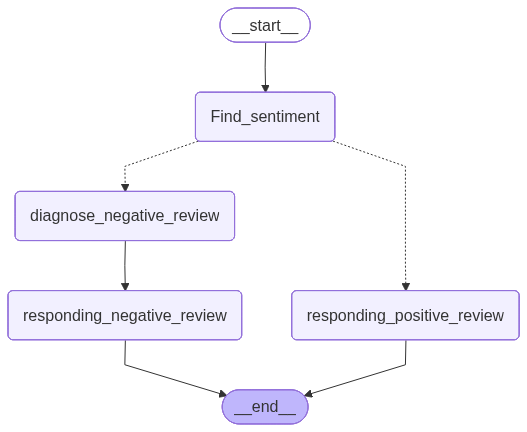

In [27]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())